## Problem statement: <br>
We need to create a model that can accurately predict future stock market prices using machine learning and previous stock market datasets.

**Dataset description:** <br>
In order to model the stock market, we have chosen a dataset from Kaggle with 8,500 files, each containing dense information from all US-based stocks, including ETFs trading on the New York Stock Exchange (NYSE), NASDAQ, and the NYSE MKT: 
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs. <br>
It is difficult but crucial to acquire high-quality data since the results of the model will be largely dependent on the accuracy and validity of the data. Incomplete datasets where there are missing data values for certain values can cause inconsistencies and introduce biases in the model if we have to remove entire instances or give default values to certain attributes. For these reasons, we made sure to find a high-quality financial data set that contains full historical daily price and volume data, last updated on November 10, 2017 by Boris Marjanovic. The dataset includes the following attributes: Date, Open, High, Low, Close, Volume, OpenInt for each stock, where each CSV file contains hundreds of rows – each corresponding to an instance in our dataset which is a single stock. Open represents the opening price, High and Low represent the corresponding maximum and minimum price during the day, Close represents the close price as adjusted for splits, Volume measures the number of shares that exchanges hands throughout the day, and OpenInt to represent Open Interest. Prices have been adjusted to account for dividends and splits.

**Goals:** <br>
Our goal is to build an accurate model that can predict the prices of certain US stocks based on various variables. With high-quality data that will undergo thorough data cleaning through a data processing stage, we want to predict the ups and downs of the stock market and create a well documented model and frontend that is both intuitive and easy for users and developers.

**Timeline:** <br>
Data cleaning/visualization 4/20 <br>
Initial machine learning, training model 4/25 <br>
Improve our model, testing for overfitting/underfitting (QA)  5/1 <br>
Build frontend for model 5/6 <br>
Write documentation for model 5/10 <br>
Test frontend 5/15 <br>
Presentations start 5/31 <br>

The timeline is subject to change based on our availability throughout the quarter. 


In [88]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

## Data Cleaning

In [89]:
path = 'us_etf_stocks_dataset\\'
#path = 'E:\\Dataset\\'

# read in major ETFs 
voo = pd.read_csv(path + 'ETFs\\voo.us.txt')
vt = pd.read_csv(path + 'ETFs\\vt.us.txt')
vti = pd.read_csv(path + 'ETFs\\vti.us.txt')
spy = pd.read_csv(path + 'ETFs\\spy.us.txt')
qqq = pd.read_csv(path + 'ETFs\\qqq.us.txt')

nvda = pd.read_csv(path + 'Stocks\\nvda.us.txt')

# checking 'OpenInt' value 
print(nvda[nvda['OpenInt'] != 0].head())
print(voo[voo['OpenInt'] != 0].head())
print(spy[spy['OpenInt'] != 0].head())

print(spy.head())
print(qqq.head())
print(vti.head())

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, OpenInt]
Index: []
         Date    Open    High     Low   Close    Volume  OpenInt
0  2005-02-25  104.77  106.00  104.68  105.79  70221808        0
1  2005-02-28  105.55  105.68  104.56  105.08  79695344        0
2  2005-03-01  105.22  105.87  105.22  105.62  54607412        0
3  2005-03-02  105.21  106.22  105.10  105.57  73733090        0
4  2005-03-03  105.99  106.20  105.15  105.61  71286823        0
         Date    Open    High     Low   Close    Volume  OpenInt
0  1999-03-10  45.722  45.750  44.967  45.665  11700414        0
1  1999-03-11  45.994  46.260  44.988  45.880  21670048        0
2  1999-03-12  45.721  45.749  44.406  44.770  19553768        0
3  1999-03-15  45.101  46.103  44.625  46.052  14245348        0
4  1999-03-16  46.253  46.643  45.74

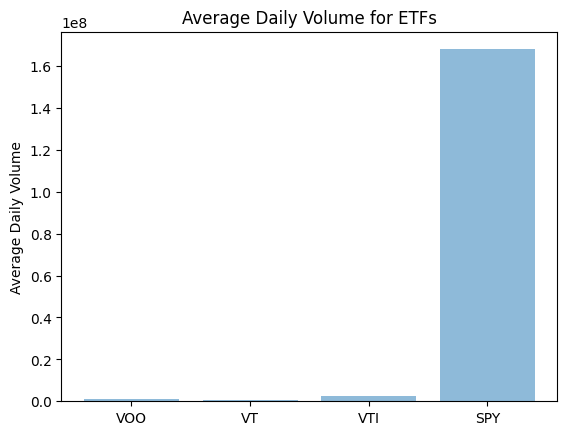

In [90]:
# visualize the daily volume for major ETFs
etfs = ['VOO', 'VT', 'VTI', 'SPY']
avg_volumes = [voo['Volume'].mean(), vt['Volume'].mean(), vti['Volume'].mean(), spy['Volume'].mean()]

y_pos = np.arange(len(etfs))

plt.bar(y_pos, avg_volumes, align='center', alpha=0.5)
plt.xticks(y_pos, etfs)
plt.ylabel('Average Daily Volume')
plt.title('Average Daily Volume for ETFs')

plt.show()

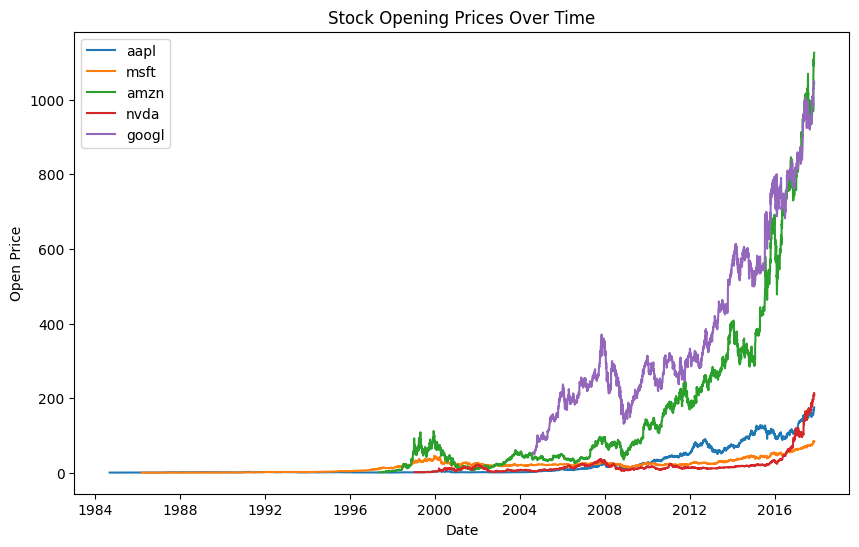

In [91]:
# top 50 companies in SPY (by weight)
spy_companies = ['aapl', 'msft', 'amzn', 'nvda', 'googl', #'brk-b', 'goog', 'fb', 'xom', 'unh', 'tsla', 'jnj', 'jpm', 'v', 
                #'pg', 'ma', 'lly', 'hd', 'cvx', 'mrk', 'abbv', 'pep', 'avgo', 'ko', 'cost', 'pfe', 'crm', 'mcd', 'wmt', 
                #'tmo', 'csco', 'bac', 'amd', 'acn','adbe', 'abt', 'cmcsa', 'dis', 'orcl', 'nflx', 'wfc', 'txn', 'dhr',
                #'vz', 'nee', 'pm', 'bmy', 'nke'
                ]

# generalized function to find the dataset for a specific set of stocks
def read_stock_data(stock_names):
    stock_data = {}
    for stock in stock_names:
        stock_data[stock] = pd.read_csv(path + f'Stocks\\{stock}.us.txt')
        # convert 'date' column to datatime objects
        stock_data[stock]['Date'] = pd.to_datetime(stock_data[stock]['Date'])
    return stock_data

# initalize data for spy_companies 
stock_data = read_stock_data(spy_companies)

# visualize the opening prices over time for spy companies 
fig = plt.figure(figsize=(10, 6))

for stock_name, data in stock_data.items():
    plt.plot(data['Date'], data['Open'], label=stock_name)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Stock Opening Prices Over Time')
plt.show()

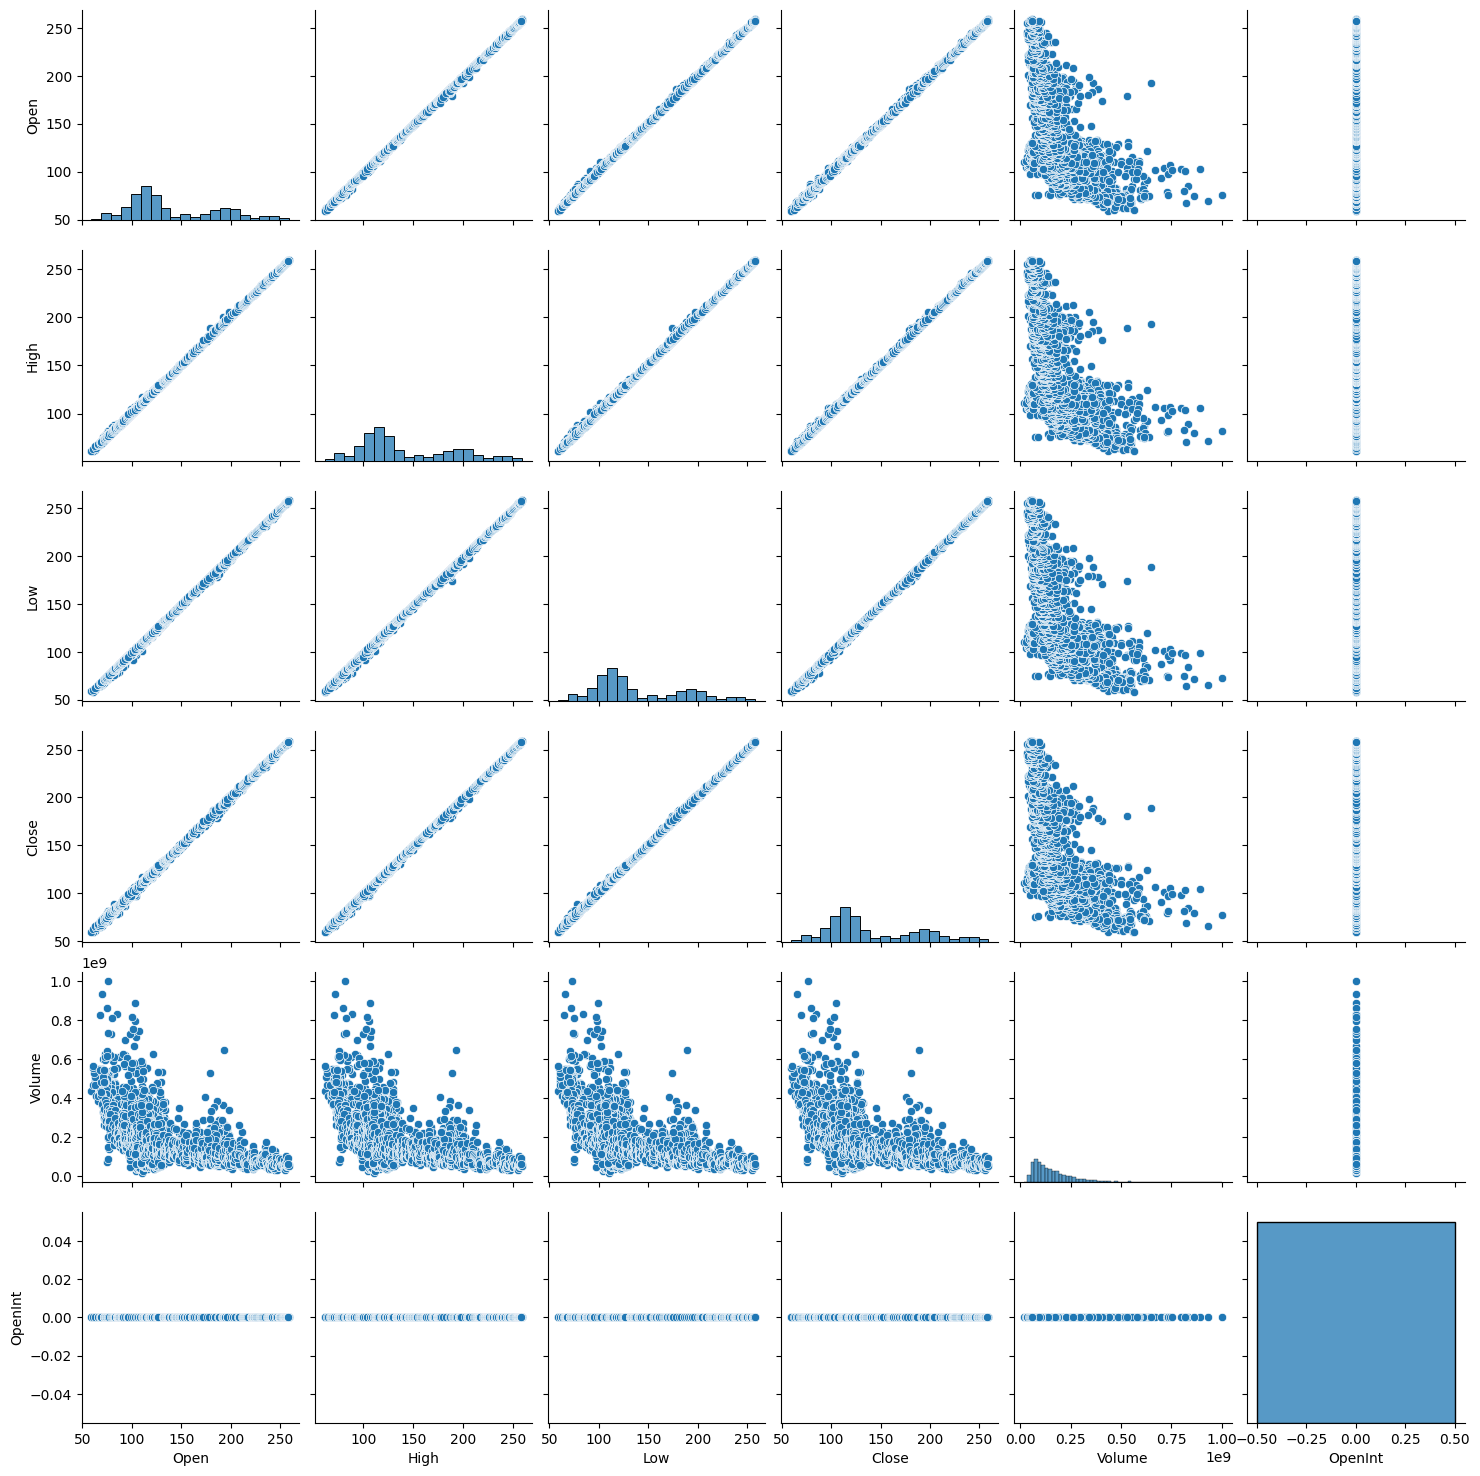

In [92]:
# Attribute pairplot
sns.pairplot(spy)

In [93]:
# general preprocessing function for stocks
def preprocess_data(ticker, timestep, ratio, date=None):
    # read in dataset for the ticker
    data = pd.read_csv(path + 'Stocks\\' + ticker + '.us.txt')
    # convert date to datetime 
    data['Date'] = pd.to_datetime(data['Date'])
    
    # crop dataset by certain date if applied
    if date:
        start_date = data['Date'] > date
        data = data[start_date]
    
    # use'Open' column only
    data_open = data.iloc[:,1:2].values
    
    # split data into training and testing data 
    split = int(len(data_open)*ratio)
    training_data = data_open[:split]
    testing_data = data_open[split:]
    
    # scale training data 
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_training_data = scaler.fit_transform(training_data)
    
    # create X_train and y_train
    X_train = []
    y_train = []
    for i in range(timestep, split):
        X_train.append(scaled_training_data[i-timestep:i, 0])
        y_train.append(scaled_training_data[i, 0])

    # convert X_train and y_train to proper shape for input to LSTM
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    return X_train, y_train, testing_data, data_open

In [94]:
# general testing function for model
def test_data(testing_data, timestep):
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_testing_data = scaler.fit_transform(testing_data)
    
    testing_data = testing_data.reshape(-1,1)
    testing_data = scaler.transform(testing_data)
    
    X_test = []
    for i in range(timestep, len(testing_data)):
        X_test.append(testing_data[i-timestep:i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    actual_stock_price = scaler.inverse_transform(testing_data)

    print(f'R2 {r2_score(actual_stock_price[timestep:], predicted_stock_price)}')
    
    return predicted_stock_price, actual_stock_price

### AAPL (Apple)

In [95]:
timestep = 80
X_train, y_train, testing_data, aapl_open = preprocess_data('aapl', timestep, .8, date='2000-1-1')
print(X_train.shape)

(3514, 80, 1)


In [96]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
55/55 [==============================] - 16s 183ms/step - loss: 0.0117
Epoch 2/50
55/55 [==============================] - 10s 187ms/step - loss: 0.0021
Epoch 3/50
55/55 [==============================] - 10s 187ms/step - loss: 0.0018
Epoch 4/50
55/55 [==============================] - 10s 178ms/step - loss: 0.0017
Epoch 5/50
55/55 [==============================] - 10s 184ms/step - loss: 0.0016
Epoch 6/50
55/55 [==============================] - 10s 174ms/step - loss: 0.0016
Epoch 7/50
55/55 [==============================] - 9s 165ms/step - loss: 0.0017
Epoch 8/50
55/55 [==============================] - 10s 173ms/step - loss: 0.0015
Epoch 9/50
55/55 [==============================] - 10s 173ms/step - loss: 0.0013
Epoch 10/50
55/55 [==============================] - 9s 171ms/step - loss: 0.0013
Epoch 11/50
55/55 [==============================] - 10s 182ms/step - loss: 0.0013
Epoch 12/50
55/55 [==============================] - 10s 183ms/step - loss: 0.0014
Epoch 13/50
55/

In [97]:
model.save('models//aapl_model.h5')

In [98]:
model = tf.keras.models.load_model('models//aapl_model.h5', compile=True) 
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 80, 50)            10400     
                                                                 
 dropout_32 (Dropout)        (None, 80, 50)            0         
                                                                 
 lstm_33 (LSTM)              (None, 80, 50)            20200     
                                                                 
 dropout_33 (Dropout)        (None, 80, 50)            0         
                                                                 
 lstm_34 (LSTM)              (None, 80, 50)            20200     
                                                                 
 dropout_34 (Dropout)        (None, 80, 50)            0         
                                                                 
 lstm_35 (LSTM)              (None, 50)               

In [99]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

26/26 [==============================] - 2s 35ms/step
R2 0.9686697285310388


In [100]:
# MSE of training
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.00023451194283552468


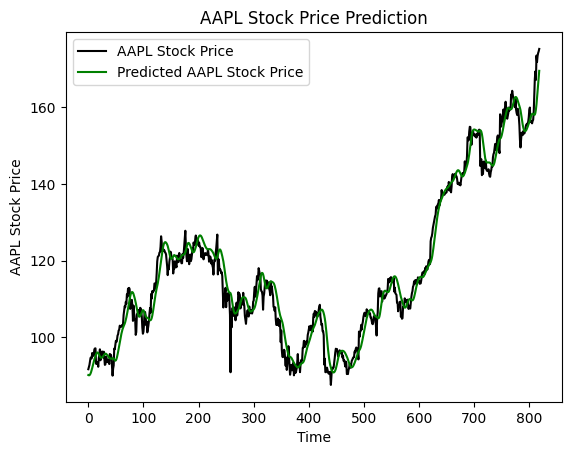

In [101]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

### NVDA (Nvidia)


In [102]:
timestep = 60
X_train, y_train, testing_data, nvda_open = preprocess_data('nvda', timestep, .8, date='2000-1-1')
print(X_train.shape)

(3536, 60, 1)


In [103]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
56/56 [==============================] - 12s 100ms/step - loss: 0.0115
Epoch 2/50
56/56 [==============================] - 6s 98ms/step - loss: 0.0033
Epoch 3/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0028
Epoch 4/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0027
Epoch 5/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0025
Epoch 6/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0022
Epoch 7/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0023
Epoch 8/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0020
Epoch 9/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0019
Epoch 10/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0020
Epoch 11/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0016
Epoch 12/50
56/56 [==============================] - 6s 104ms/step - loss: 0.0017
Epoch 13/50
56/56 [==========

In [104]:
model.save('models//nvda_model.h5')

In [105]:
model = tf.keras.models.load_model('models//nvda_model.h5', compile=True) 
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_36 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_37 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_37 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_38 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_38 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_39 (LSTM)              (None, 50)               

In [106]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.0003841293219011277


In [107]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

27/27 [==============================] - 3s 27ms/step
R2 0.9964551577432814


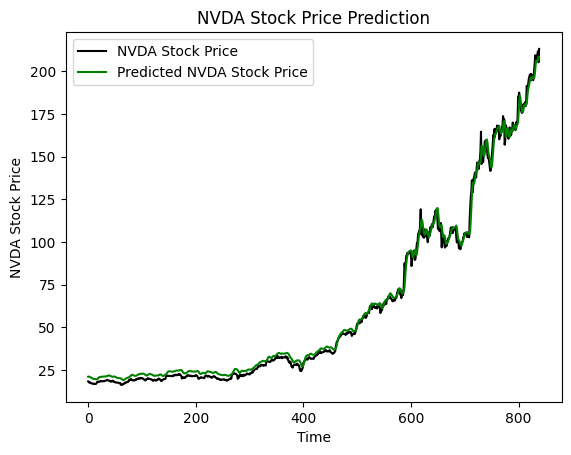

In [108]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'NVDA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

### MSFT (Microsoft)

In [109]:
timestep = 60
X_train, y_train, testing_data, msft_open = preprocess_data('msft', timestep, 0.8, date='2000-1-1')

In [110]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
56/56 [==============================] - 11s 102ms/step - loss: 0.0107
Epoch 2/50
56/56 [==============================] - 6s 100ms/step - loss: 0.0032
Epoch 3/50
56/56 [==============================] - 6s 103ms/step - loss: 0.0030
Epoch 4/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0026
Epoch 5/50
56/56 [==============================] - 5s 97ms/step - loss: 0.0024
Epoch 6/50
56/56 [==============================] - 6s 104ms/step - loss: 0.0025
Epoch 7/50
56/56 [==============================] - 6s 98ms/step - loss: 0.0021
Epoch 8/50
56/56 [==============================] - 5s 98ms/step - loss: 0.0019
Epoch 9/50
56/56 [==============================] - 6s 102ms/step - loss: 0.0017
Epoch 10/50
56/56 [==============================] - 6s 99ms/step - loss: 0.0017
Epoch 11/50
56/56 [==============================] - 5s 98ms/step - loss: 0.0016
Epoch 12/50
56/56 [==============================] - 6s 102ms/step - loss: 0.0016
Epoch 13/50
56/56 [===========

In [111]:
model.save('msft_model.h5')

In [112]:
model = tf.keras.models.load_model('models//msft_model.h5', compile=True) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [113]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.0003260041121393442


In [114]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

27/27 [==============================] - 2s 25ms/step
R2 0.9908400512878972


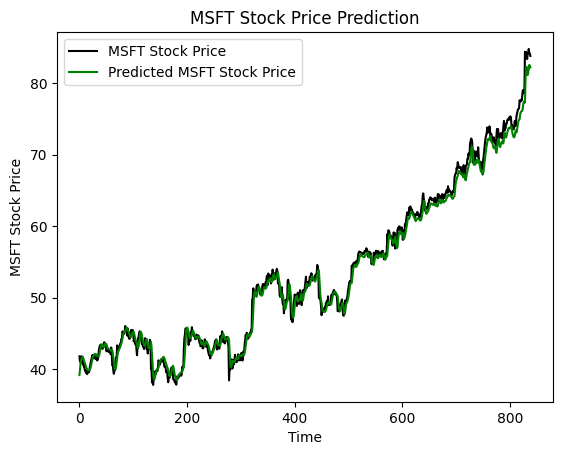

In [115]:
# Plotting
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'MSFT Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted MSFT Stock Price')
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend()
plt.show()

### GOOGL (Google)

In [116]:
timestep = 50
X_train, y_train, testing_data, googl_open = preprocess_data('googl', timestep, .85)

print(X_train.shape)

(2783, 50, 1)


In [117]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
44/44 [==============================] - 9s 82ms/step - loss: 0.0191
Epoch 2/100
44/44 [==============================] - 4s 81ms/step - loss: 0.0030
Epoch 3/100
44/44 [==============================] - 4s 84ms/step - loss: 0.0027
Epoch 4/100
44/44 [==============================] - 4s 82ms/step - loss: 0.0027
Epoch 5/100
44/44 [==============================] - 4s 86ms/step - loss: 0.0023
Epoch 6/100
44/44 [==============================] - 4s 89ms/step - loss: 0.0022
Epoch 7/100
44/44 [==============================] - 4s 88ms/step - loss: 0.0020
Epoch 8/100
44/44 [==============================] - 4s 94ms/step - loss: 0.0020
Epoch 9/100
44/44 [==============================] - 4s 90ms/step - loss: 0.0020
Epoch 10/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0018
Epoch 11/100
44/44 [==============================] - 4s 95ms/step - loss: 0.0019
Epoch 12/100
44/44 [==============================] - 4s 87ms/step - loss: 0.0017
Epoch 13/100
44/44 [=====

In [118]:
model.save('models//googl_model.h5')

In [119]:
model = tf.keras.models.load_model('models//googl_model.h5', compile=True) 
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 50, 50)            10400     
                                                                 
 dropout_44 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_45 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_45 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_46 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_46 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_47 (LSTM)              (None, 50)              

In [120]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.00025593527243472636


In [121]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

15/15 [==============================] - 1s 19ms/step
R2 0.9745343332282779


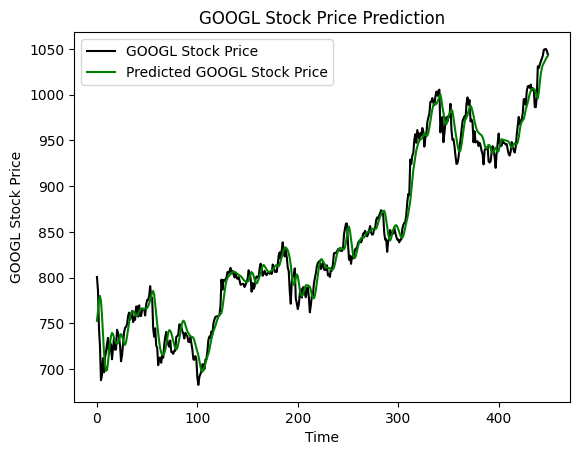

In [122]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'GOOGL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted GOOGL Stock Price')
plt.title('GOOGL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOGL Stock Price')
plt.legend()
plt.show()

### AMZN (Amazon)

In [123]:
timestep = 50
X_train, y_train, testing_data, amzn_open = preprocess_data('amzn', timestep, .8, date='2000-1-1')
print(X_train.shape)

(3543, 50, 1)


In [124]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
56/56 [==============================] - 11s 84ms/step - loss: 0.0119
Epoch 2/50
56/56 [==============================] - 5s 90ms/step - loss: 0.0017
Epoch 3/50
56/56 [==============================] - 5s 86ms/step - loss: 0.0015
Epoch 4/50
56/56 [==============================] - 5s 81ms/step - loss: 0.0016
Epoch 5/50
56/56 [==============================] - 4s 80ms/step - loss: 0.0014
Epoch 6/50
56/56 [==============================] - 5s 80ms/step - loss: 0.0015
Epoch 7/50
56/56 [==============================] - 4s 80ms/step - loss: 0.0016
Epoch 8/50
56/56 [==============================] - 4s 80ms/step - loss: 0.0013
Epoch 9/50
56/56 [==============================] - 4s 80ms/step - loss: 0.0013
Epoch 10/50
56/56 [==============================] - 4s 80ms/step - loss: 0.0012
Epoch 11/50
56/56 [==============================] - 5s 81ms/step - loss: 0.0011
Epoch 12/50
56/56 [==============================] - 5s 81ms/step - loss: 0.0012
Epoch 13/50
56/56 [=================

In [125]:
model.save('models//amzn_model.h5')

In [126]:
model = tf.keras.models.load_model('models//amzn_model.h5', compile=True) 
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 50, 50)            10400     
                                                                 
 dropout_48 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_49 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_49 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_50 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_50 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_51 (LSTM)              (None, 50)              

In [127]:
train_score = model.evaluate(X_train, y_train, verbose=0)
print(train_score)

0.0005317315808497369


In [128]:
predicted_stock_price, actual_stock_price = test_data(testing_data, timestep)

27/27 [==============================] - 2s 20ms/step
R2 0.9784154413880023


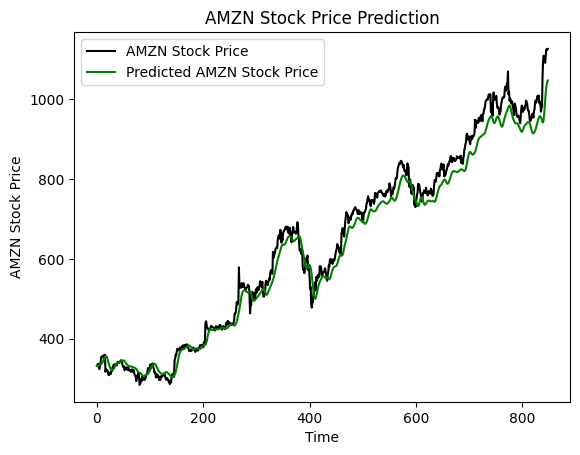

In [129]:
plt.plot(actual_stock_price[timestep:], color = 'black', label = 'AMZN Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AMZN Stock Price')
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.show()

## Generalized Model

In [130]:
train_stocks = ['aapl', 'msft', 'amzn', 'nvda', 'googl']
test_stocks = ['ge', 'ibm', 'mo', 'hpq', 'ko']

In [131]:
def preprocess_data(name, timestep = 50, date = None):
    scaler = MinMaxScaler()

    data = pd.read_csv(f'stocks\\{name}.us.txt')
    data['Date'] = pd.to_datetime(data['Date'])

    if date:
        start_date = data['Date'] >= date
        data = data[start_date]

    data = data.iloc[:,[1,4]].values
    data = data.reshape(-1, 1)
    scaled_data = scaler.fit_transform(data)

    X_train = []
    y_train = []
    for i in range(timestep, len(data)):
        X_train.append(scaled_data[i - timestep:i, 0])
        y_train.append(scaled_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    return X_train, y_train

In [132]:
def train_data(names, timestep = 50, date = None, epochs = 50, batch_size = 32, dropout = 0.2, units = 50, optimizer = 'adam', loss = 'mean_squared_error'):
    model = Sequential()

    model.add(LSTM(units=units, return_sequences=True, input_shape=(timestep, 1)))
    model.add(Dropout(dropout))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(units=units))
    model.add(Dropout(dropout))

    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss=loss)

    for name in names:
        X_train, y_train = preprocess_data(name, timestep = timestep, date = date)
        model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    
    return model

In [133]:
def predict_data(model, names, timestep = 50, date = None):
    for name in names:
        scaler = MinMaxScaler()

        # data = pd.read_csv(f'stocks\\{name}.us.txt')
        data = pd.read_csv(f'us_etf_stocks_dataset\\stocks\\{name.lower()}.us.txt')

        if date:
            start_date = data['Date'] >= date
            data = data[start_date]

        data = data.iloc[:,[1,4]].values
        data = data.reshape(-1, 1)
        scaled_data = scaler.fit_transform(data)

        X_test = []
        for i in range(timestep, len(scaled_data)):
            X_test.append(scaled_data[i - timestep:i, 0])
        
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        prediction = model.predict(X_test)
        prediction = scaler.inverse_transform(prediction)

        print(f'MSE: {mean_squared_error(data[timestep:], prediction)}')
        print(f'R2: {r2_score(data[timestep:], prediction)}')

        name = name.upper()
        plt.plot(data[timestep:], color = 'black', label = f'Actual {name} Stock Price')
        plt.plot(prediction, color = 'green', label = f'Predicted {name} Stock Price')
        plt.title(f'{name} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

In [134]:
model = train_data(train_stocks, timestep=50, date = '2000-01-01', epochs = 10, batch_size = 64)

Epoch 1/10
140/140 [==============================] - 18s 90ms/step - loss: 0.0053
Epoch 2/10
140/140 [==============================] - 12s 88ms/step - loss: 0.0013
Epoch 3/10
140/140 [==============================] - 13s 90ms/step - loss: 9.8585e-04
Epoch 4/10
140/140 [==============================] - 12s 88ms/step - loss: 9.6999e-04
Epoch 5/10
140/140 [==============================] - 12s 89ms/step - loss: 9.7960e-04
Epoch 6/10
140/140 [==============================] - 12s 88ms/step - loss: 9.6980e-04
Epoch 7/10
140/140 [==============================] - 12s 88ms/step - loss: 8.1163e-04
Epoch 8/10
140/140 [==============================] - 13s 89ms/step - loss: 8.6016e-04
Epoch 9/10
140/140 [==============================] - 13s 90ms/step - loss: 7.8725e-04
Epoch 10/10
140/140 [==============================] - 13s 91ms/step - loss: 7.7356e-04
Epoch 1/10
140/140 [==============================] - 15s 104ms/step - loss: 6.3102e-04
Epoch 2/10
140/140 [=============================

In [135]:
model.save('models//generalized_model.h5')

In [136]:
model = tf.keras.models.load_model('models//generalized_model.h5', compile=False) 

280/280 [==============================] - 7s 21ms/step
MSE: 0.3842830375388854
R2: 0.9935419264536958


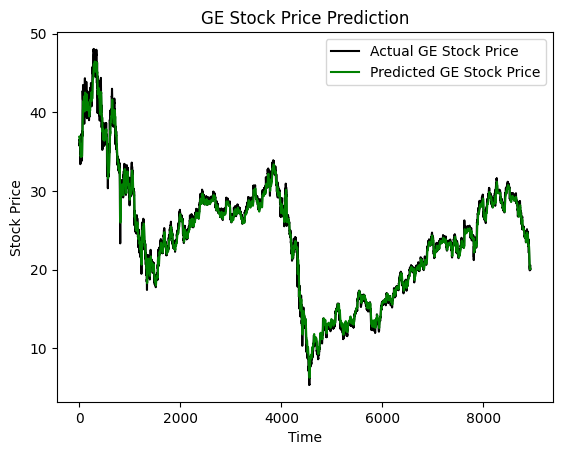

280/280 [==============================] - 6s 21ms/step
MSE: 5.53320727179018
R2: 0.996094532239277


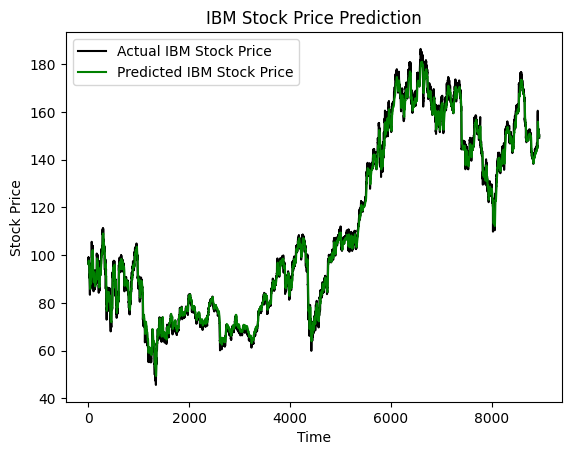

280/280 [==============================] - 6s 21ms/step
MSE: 0.6987759380827652
R2: 0.9979308963925467


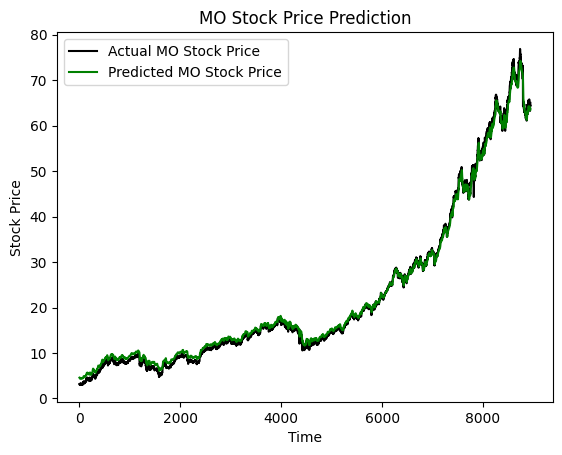

280/280 [==============================] - 6s 21ms/step
MSE: 0.18252794574447567
R2: 0.9915153540316094


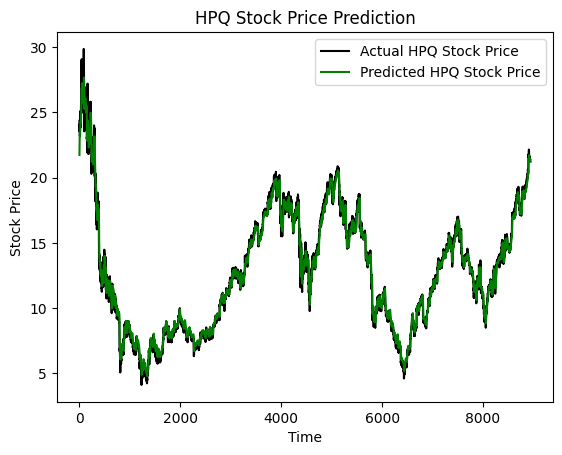

280/280 [==============================] - 6s 21ms/step
MSE: 0.23564715276418344
R2: 0.9968998917452071


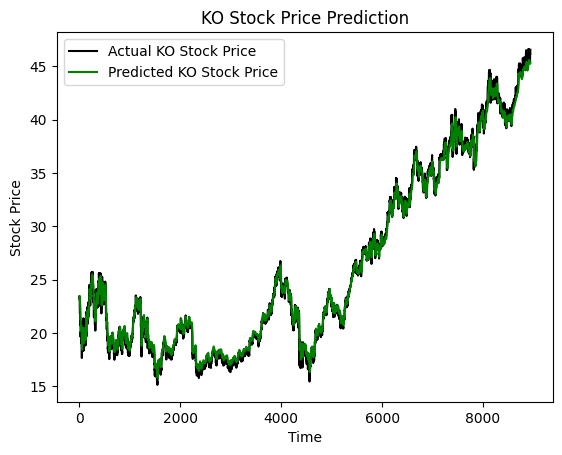

In [137]:
predict_data(model, test_stocks, date = '2000-01-01')

## Frontend

In [138]:
from flask import Flask, request, jsonify, render_template

In [139]:
gen_model = tf.keras.models.load_model('models//generalized_model.h5', compile=False) 
gen_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 50, 50)            10400     
                                                                 
 dropout_52 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_53 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_53 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_54 (LSTM)              (None, 50, 50)            20200     
                                                                 
 dropout_54 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_55 (LSTM)              (None, 50)              

In [140]:
def predict_data(model, names, timestep = 50, date = None):
    for name in names:
        scaler = MinMaxScaler()

        data = pd.read_csv(path + f'Stocks\\{name}.us.txt')
        #data = pd.read_csv(path + f'Stocks/{name.lower()}.us.txt')
        if date:
            start_date = data['Date'] >= date
            data = data[start_date]


        data = data['Open']
        data = np.array(data)
        data = data.reshape(-1, 1)
        scaled_data = scaler.fit_transform(data)

        X_test = []
        for i in range(timestep, len(scaled_data)):
            X_test.append(scaled_data[i - timestep:i, 0])
        
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        prediction = model.predict(X_test)
        prediction = scaler.inverse_transform(prediction)

        MSE = mean_squared_error(data[timestep:], prediction)
        R2 = r2_score(data[timestep:], prediction)

        name = name.upper()
        
        plt.plot(data[timestep:], color = 'black', label = f'Actual {name} Stock Price')
        plt.plot(prediction, color = 'green', label = f'Predicted {name} Stock Price')
        plt.title(f'{name} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.savefig('./static/recent_img.png')
        # plt.show()
        plt.clf()
        return(MSE, R2)


In [141]:
app = Flask(__name__)

@app.route('/', methods=['GET'])
def home():
    return render_template("index.html")

@app.route('/', methods=['POST'])
def predict():
    values = list(request.form.values())
    stockfilename = ''.join(values)

    try:
        # check if ticker is in our dataset
        pd.read_csv(path + f'Stocks\\{stockfilename}.us.txt')

        ans = predict_data(gen_model, [stockfilename], timestep=50, date=None)
        return render_template("output.html", data=ans)
    
    except Exception as e:
        # Handle any other exceptions that may occur
        error_msg = "The stock ticker entered is not found. Please try another ticker." 
        print(e)
        return render_template("index.html", error=error_msg)


if __name__ == "__main__":
    app.run(port=2000, debug = False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:2000
Press CTRL+C to quit
127.0.0.1 - - [04/Jun/2023 21:53:54] "GET / HTTP/1.1" 200 -


357/357 [==============================] - 9s 22ms/step


127.0.0.1 - - [04/Jun/2023 21:54:06] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:54:06] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:54:16] "GET / HTTP/1.1" 200 -


103/103 [==============================] - 2s 20ms/step


127.0.0.1 - - [04/Jun/2023 21:54:22] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:54:22] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:54:44] "GET / HTTP/1.1" 200 -


260/260 [==============================] - 6s 21ms/step


127.0.0.1 - - [04/Jun/2023 21:54:52] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:54:52] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:54:58] "GET / HTTP/1.1" 200 -


248/248 [==============================] - 5s 21ms/step


127.0.0.1 - - [04/Jun/2023 21:55:06] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:55:06] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:55:12] "GET / HTTP/1.1" 200 -


147/147 [==============================] - 3s 21ms/step


127.0.0.1 - - [04/Jun/2023 21:55:20] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:55:20] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:55:33] "GET / HTTP/1.1" 200 -


160/160 [==============================] - 4s 22ms/step


127.0.0.1 - - [04/Jun/2023 21:55:40] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2023 21:55:40] "GET /static/recent_img.png HTTP/1.1" 200 -


<Figure size 640x480 with 0 Axes>